<a href="https://colab.research.google.com/github/george-zakharov/ml-random/blob/master/Tweet_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an exploration for Kaggle competition https://www.kaggle.com/c/nlp-getting-started/overview

# Install libs

In [15]:
# Load TF 2.x
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

2.3.0


In [23]:
from google.colab import files

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Kaggle API

In [2]:
!pip install kaggle

In [3]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [5]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 39.4MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.4MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 132MB/s]


# EDA

## Train data

In [6]:
train_data = pd.read_csv('train.csv')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


It looks like we have nulls in data as was mentioned in competition

In [8]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

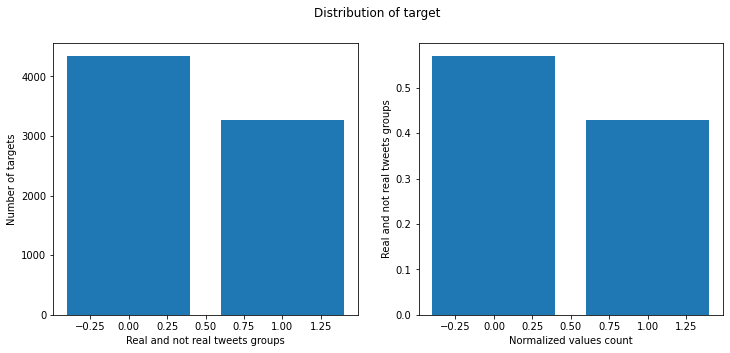

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.bar(train_data['target'].value_counts().index, train_data['target'].value_counts())
plt.xlabel('Real and not real tweets groups')
plt.ylabel('Number of targets')

plt.subplot(122)
plt.bar(train_data['target'].value_counts().index, train_data['target'].value_counts(normalize=True))
plt.xlabel('Normalized values count')
plt.ylabel('Real and not real tweets groups')

plt.suptitle('Distribution of target')
plt.show()

In [13]:
# Let's check how many nulls do we have in the data
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Test data

In [7]:
test_data = pd.read_csv('test.csv')

In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


# Data processing

Let's work only with text data and targets

In [10]:
all_words = []
for sent in train_data['text']:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [11]:
unique_words = set(all_words)
print(len(unique_words))

27291


In [12]:
vocab_length = 28000

In [17]:
embedded_sentences = [one_hot(sent, vocab_length) for sent in train_data['text']]
print(embedded_sentences)

[[27575, 18096, 20679, 6190, 6501, 17186, 7284, 3204, 3693, 27505, 20188, 25199, 3788], [18864, 11988, 22138, 24530, 11404, 11965, 6076], [3788, 7174, 4950, 795, 27572, 12059, 19694, 20679, 13209, 15158, 10334, 15533, 4274, 3432, 26162, 12920, 11688, 12059, 25909, 22166, 20679, 12860], [13412, 11493, 19988, 24435, 4503, 26162, 22166, 12059, 23768], [21695, 345, 10768, 7284, 12830, 14777, 7315, 2387, 8308, 9409, 14777, 4503, 2349, 10448, 23625, 1896], [10059, 9013, 23768, 11131, 4172, 8070, 12059, 20223, 7676, 15387, 795, 15144, 18987, 11988, 13329, 4503], [3134, 15399, 22254, 367, 20588, 7664, 25144, 17186, 10681, 12059, 20512, 17735, 25932, 22881], [1617, 2607, 23696, 17186, 6190, 18706, 11988, 1207, 26839, 17413, 23625, 11988, 12059, 6190, 22679], [20872, 16895, 25403, 26162, 14843, 1238, 12059, 6190, 25999, 21336, 6190, 14680], [1617, 8375, 11771, 6190, 10162, 5307, 24612, 795, 27575, 12243], [2106, 19988, 26173, 14777, 6190, 14501, 13013, 17322, 27586], [23238, 19122, 7845, 5307, 2

In [19]:
# Let's count max sent vector size
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(train_data['text'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [22]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[27575 18096 20679 ...     0     0     0]
 [18864 11988 22138 ...     0     0     0]
 [ 3788  7174  4950 ...     0     0     0]
 ...
 [20985  5812 15140 ...     0     0     0]
 [ 8228  4388 16393 ...     0     0     0]
 [ 6190 18353 24567 ...     0     0     0]]


# Model

In [29]:
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 20)            560000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1441      
Total params: 561,441
Trainable params: 561,441
Non-trainable params: 0
_________________________________________________________________
None


# Train

In [31]:
history = model.fit(padded_sentences, train_data['target'], epochs=20, verbose=1)

Epoch 1/20
238/238 [==============================] - 1s 6ms/step - loss: 0.6454 - acc: 0.6342
Epoch 2/20
238/238 [==============================] - 1s 6ms/step - loss: 0.4574 - acc: 0.8085
Epoch 3/20
238/238 [==============================] - 2s 6ms/step - loss: 0.2993 - acc: 0.8998
Epoch 4/20
238/238 [==============================] - 1s 6ms/step - loss: 0.1941 - acc: 0.9430
Epoch 5/20
238/238 [==============================] - 2s 6ms/step - loss: 0.1272 - acc: 0.9665
Epoch 6/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0879 - acc: 0.9781
Epoch 7/20
238/238 [==============================] - 2s 6ms/step - loss: 0.0644 - acc: 0.9837
Epoch 8/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0497 - acc: 0.9877
Epoch 9/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0398 - acc: 0.9895
Epoch 10/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0328 - acc: 0.9905
Epoch 11/20
238/238 [============================

In [33]:
loss, accuracy = model.evaluate(padded_sentences, train_data['target'], verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 99.619073
